# 베이스라인
* Efficient-net B2
* result
    - train loss : 0.5161
    - validation loss : 1.3064
    - f1 score : 0.6652
    - epoch : 22
    - public 점수 : 0.6067131031
    - private 점수 : 0.6057289787

In [1]:
import gc
import random
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import os
import cv2

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import timm

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
CFG = {
    'IMG_SIZE': 260,
    'EPOCHS': 1000,
    'LEARNING_RATE': 1e-3,
    'BATCH_SIZE': 16,
    'PATIENCE': 10,
    'FILENAME': 'baseline',
    'SEED': 6
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

In [5]:
running_colab = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
if running_colab:
    data_path = '/content/drive/MyDrive/Colab Notebooks/ai6th/data/optiver/'
else:
    data_path = '../../data/'

In [6]:
df = pd.read_csv(os.path.join(data_path, 'train.csv'))
df.loc[3896, 'artist'] = 'Titian'
df.loc[3986, 'artist'] = 'Alfred Sisley'

In [7]:
artists = df.groupby('artist')[['id']].count().rename(columns={'id':'count'}).reset_index()

In [8]:
# Label Encoding
le = preprocessing.LabelEncoder()
df['artist'] = le.fit_transform(df['artist'].values)

In [9]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=CFG['SEED'])

In [10]:
train_df = train_df.sort_values(by=['id'])

In [11]:
val_df = val_df.sort_values(by=['id'])

In [12]:
def get_data(df, infer=False):
    if infer:
        return df['img_path'].apply(lambda p: os.path.join(data_path, p)).values
    return df['img_path'].apply(lambda p: os.path.join(data_path, p)).values, df['artist'].values

In [13]:
train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

In [14]:
from torchvision.transforms import ToTensor


class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transforms=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transforms = transforms if transforms else ToTensor()

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        
        if self.labels is not None:
            label = self.labels[index]
            return image, label
        else:
            return image
    
    def __len__(self):
        return len(self.img_paths)

In [15]:
train_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE']*2,CFG['IMG_SIZE']*2),
    A.RandomCrop(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE']*2,CFG['IMG_SIZE']*2),
    A.RandomCrop(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
])

In [16]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(0)

In [17]:
train_dataset = CustomDataset(train_img_paths, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, worker_init_fn=seed_worker, generator=g, num_workers=0)

val_dataset = CustomDataset(val_img_paths, val_labels, valid_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, worker_init_fn=seed_worker, generator=g, num_workers=0)

In [18]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.backbone = timm.create_model('efficientnet_b2', pretrained=True, num_classes=512)
        self.classifier = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(512, num_classes)
        )
            
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [19]:
def clear_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [20]:
def train(model, optimizer, criterion, train_loader, device):
    model.train()
    train_loss = []
    bar = tqdm(enumerate(train_loader), total = len(train_loader), desc='Train Loop')
    for idx, (img, label) in bar:
        img, label = img.float().to(device), label.long().to(device)
        
        optimizer.zero_grad()

        model_pred = model(img)
        
        loss = criterion(model_pred, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        bar.set_postfix(train_loss = f'{loss.item():.4f}')
    return np.mean(train_loss)

In [21]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation(model, criterion, test_loader, device):
    model.eval()
    
    model_preds = []
    true_labels = []
    
    val_loss = []
    
    with torch.no_grad():
        for img, label in iter(test_loader):
            img, label = img.float().to(device), label.long().to(device)
            
            model_pred = model(img)
            
            loss = criterion(model_pred, label)
            
            val_loss.append(loss.item())
            
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()
        
    val_f1 = competition_metric(true_labels, model_preds)
    return np.mean(val_loss), val_f1

In [22]:
time_now = datetime.now()
run_id = time_now.strftime("%Y%m%d%H%M%S")
os.makedirs(os.path.join(data_path, f'./runs/{run_id}'), exist_ok=True)
print(f'{run_id=}')

run_id='20231220161801'


In [23]:
def train_epoch(model, optimizer, train_loader, test_loader, scheduler, device):
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    early_stopping = EarlyStopping(patience=CFG['PATIENCE'], verbose=True)
    
    best_score = 0
    train_loss_list, val_loss_list = [], []
    
    for epoch in range(1,CFG["EPOCHS"]+1):
        tr_loss = train(model, optimizer, criterion, train_loader, device)
        val_loss, val_score = validation(model, criterion, test_loader, device)
        train_loss_list.append(tr_loss)
        val_loss_list.append(val_loss)
        
        if scheduler is not None:
            scheduler.step()
            
        if best_score < val_score:
            print(f'**Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
            best_score = val_score
            torch.save(model, os.path.join(data_path, f'runs/{run_id}/best_model.pt'))
        else:
            print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
        clear_mem()
        if early_stopping(val_score):
            print(f'Epoch [{epoch}], early stopping')
            break
    return (train_loss_list, val_loss_list)

In [24]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        
        return self.early_stop

In [25]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

train_loss_list, val_loss_list = train_epoch(model, optimizer, train_loader, val_loader, scheduler, device)

Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [1], Train Loss : [2.65099] Val Loss : [2.36027] Val F1 Score : [0.22946]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [2], Train Loss : [1.97480] Val Loss : [1.87267] Val F1 Score : [0.36324]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [3], Train Loss : [1.64175] Val Loss : [1.58331] Val F1 Score : [0.48182]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [4], Train Loss : [1.45983] Val Loss : [1.43648] Val F1 Score : [0.51587]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [5], Train Loss : [1.31044] Val Loss : [1.39948] Val F1 Score : [0.50271]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.5158730427654672


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [6], Train Loss : [1.18384] Val Loss : [1.48635] Val F1 Score : [0.51058]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.5158730427654672


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [7], Train Loss : [1.08798] Val Loss : [1.51857] Val F1 Score : [0.53175]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [8], Train Loss : [1.03578] Val Loss : [1.52948] Val F1 Score : [0.54103]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [9], Train Loss : [0.94926] Val Loss : [1.43163] Val F1 Score : [0.58596]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.88785] Val Loss : [1.48703] Val F1 Score : [0.55288]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.5859619219405383


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [11], Train Loss : [0.81003] Val Loss : [1.35152] Val F1 Score : [0.60927]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.81361] Val Loss : [1.48482] Val F1 Score : [0.57211]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6092705913443646


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [13], Train Loss : [0.74378] Val Loss : [1.27119] Val F1 Score : [0.61527]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.72702] Val Loss : [1.31830] Val F1 Score : [0.58725]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6152700772820502


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.68730] Val Loss : [1.37939] Val F1 Score : [0.60838]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.6152700772820502


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.64477] Val Loss : [1.39119] Val F1 Score : [0.58898]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.6152700772820502


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.64664] Val Loss : [1.27296] Val F1 Score : [0.61480]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.6152700772820502


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [18], Train Loss : [0.61647] Val Loss : [1.30714] Val F1 Score : [0.63883]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [19], Train Loss : [0.60535] Val Loss : [1.27690] Val F1 Score : [0.65030]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.56088] Val Loss : [1.43187] Val F1 Score : [0.59205]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6502990960723527


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.51776] Val Loss : [1.36892] Val F1 Score : [0.63423]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.6502990960723527


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [22], Train Loss : [0.51619] Val Loss : [1.30642] Val F1 Score : [0.66522]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.53380] Val Loss : [1.78610] Val F1 Score : [0.61922]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6652223509342962


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.50478] Val Loss : [1.51107] Val F1 Score : [0.60962]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.6652223509342962


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.48297] Val Loss : [1.38650] Val F1 Score : [0.64350]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.6652223509342962


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.49035] Val Loss : [1.53345] Val F1 Score : [0.62212]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.6652223509342962


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.48031] Val Loss : [1.35637] Val F1 Score : [0.63507]
EarlyStopping counter: 5 out of 10
Best F1 score from now: 0.6652223509342962


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.44903] Val Loss : [1.49593] Val F1 Score : [0.63050]
EarlyStopping counter: 6 out of 10
Best F1 score from now: 0.6652223509342962


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.43249] Val Loss : [1.42037] Val F1 Score : [0.64396]
EarlyStopping counter: 7 out of 10
Best F1 score from now: 0.6652223509342962


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.42442] Val Loss : [1.28149] Val F1 Score : [0.65911]
EarlyStopping counter: 8 out of 10
Best F1 score from now: 0.6652223509342962


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [31], Train Loss : [0.41227] Val Loss : [1.54178] Val F1 Score : [0.61734]
EarlyStopping counter: 9 out of 10
Best F1 score from now: 0.6652223509342962


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [32], Train Loss : [0.43613] Val Loss : [1.34789] Val F1 Score : [0.64355]
EarlyStopping counter: 10 out of 10
Best F1 score from now: 0.6652223509342962
Epoch [32], early stopping


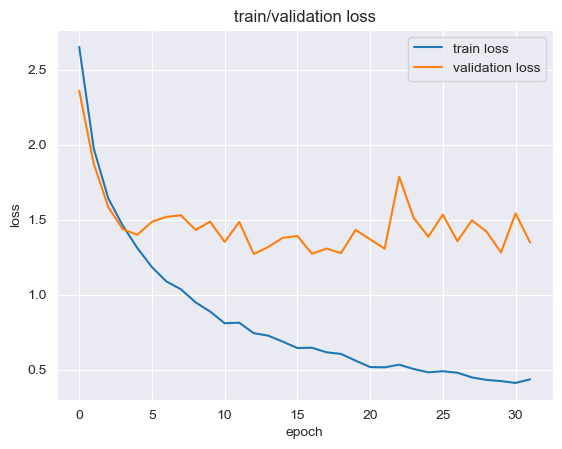

In [26]:
sns.lineplot(train_loss_list, label='train loss')
sns.lineplot(val_loss_list, label='validation loss')
plt.xlabel("epoch")
plt.ylabel('loss')
plt.title('train/validation loss')
plt.show()

In [27]:
test_df = pd.read_csv(os.path.join(data_path, './test.csv'))
test_df.head()

,id,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg


In [28]:
test_img_paths = get_data(test_df, infer=True)

In [29]:
test_dataset = CustomDataset(test_img_paths, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [30]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    
    model_preds = []
    
    with torch.no_grad():
        for img in test_loader:
            img = img.float().to(device)
            
            model_pred = model(img)
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
    
    print('Done.')
    return model_preds

In [31]:
checkpoint = os.path.join(data_path, f'runs/{run_id}/best_model.pt')
print(f'CHECKPOINT LOADED: {checkpoint}')
infer_model = torch.load(checkpoint)
infer_model.to(device)
infer_model.eval()

CHECKPOINT LOADED: ../../data/runs/20231220161801/best_model.pt


BaseModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1,

In [32]:
preds = inference(infer_model, test_loader, device)

Done.


In [33]:
preds = le.inverse_transform(preds)

In [34]:
submit = pd.read_csv(os.path.join(data_path, './sample_submission.csv'))

In [35]:
submit['artist'] = preds

In [36]:
submit.head()

,id,artist
0,TEST_00000,Edgar Degas
1,TEST_00001,Pablo Picasso
2,TEST_00002,Peter Paul Rubens
3,TEST_00003,Albrecht Du rer
4,TEST_00004,Amedeo Modigliani


In [37]:
submit.to_csv(os.path.join(data_path, f"./submit_{CFG['FILENAME']}.csv"), index=False)